In [1]:
from collections import namedtuple
from bbchallenge import *
from typing import List, Dict
import copy
import drawSvg as draw

In [2]:
DB_PATH = "all_5_states_undecided_machines_with_global_header"

In [3]:
m = get_machine_i(DB_PATH,11270715)

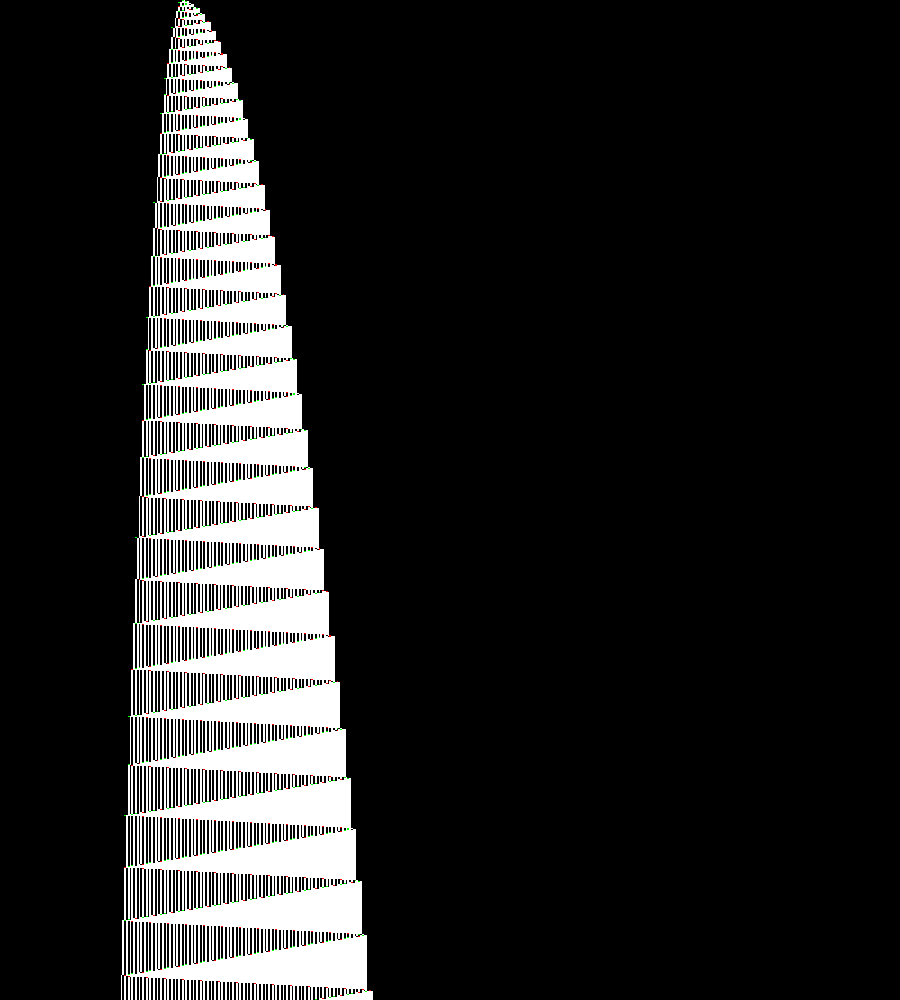

In [4]:
img = tm_trace_to_image(m, origin=0.2, width=500, height=10000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

In [7]:
def tm_trace_to_text(machine, nb_steps):
    trace = get_tm_trace(machine, nb_steps)
    
    min_pos, max_pos = get_trace_extreme_pos(trace)
    
    for tape, state, head_pos in trace:
        print(chr(ord("A")+state), end=" ")
        for pos in range(min_pos, max_pos+1):
            if pos == head_pos:
                print(">", end="")
            else:
                print(" ", end="")

            if pos not in tape:
                print("#", end=" ")
            else:
                print(tape[pos], end=" ")
        print()
        
    print(min_pos, max_pos)

In [5]:
def get_tm_trace(machine, nb_steps, initial_step=0):
    tape = {}
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    
    tapes = [(copy.copy(tape),0,0)]
    
    curr_step = 0
    for row in range(1,nb_steps+initial_step):
        last_pos = curr_pos
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        curr_step += 1
        
        if curr_step >= initial_step:
            tapes.append((copy.copy(tape),curr_state,curr_pos))
       
    return tapes

def get_trace_extreme_pos(trace):
    min_pos = 0
    max_pos = 0
    for tape,_,_ in trace:
        if len(tape.keys()) == 0:
            continue
        min_pos = min(min_pos,min(tape.keys()))
        max_pos = max(max_pos,max(tape.keys()))
        
    return min_pos, max_pos

StrokeAnnotation = namedtuple('StrokeAnnotation', ('step', 'pos', 'color', 'width'))
def tm_trace_to_svg(machine, nb_steps, initial_step=0, cell_size=16, 
                    debug=False, stroke_annotations:Dict[int,Dict[int,StrokeAnnotation]]={}):
    trace = get_tm_trace(machine, nb_steps, initial_step=initial_step)
    
    min_pos, max_pos = get_trace_extreme_pos(trace)
    tape_size = max_pos-min_pos+1
    
    draw_w = tape_size*cell_size
    draw_h = nb_steps*cell_size
    
    d = draw.Drawing(draw_w, draw_h, origin=(0,0), displayInline=False)
    
    COLOR_WHEEL = [[255, 0, 0],[255, 128, 0],[0, 0, 255],[0, 255, 0],[255, 0, 255],[0, 255, 255],[255, 255, 0]]
    
    def get_cell_rgb_color(tape, state, head_pos, pos):
        if pos == head_pos:
            return COLOR_WHEEL[state]
        if pos not in tape:
            return [90,90,90]
        if tape[pos] == 0:
            return [0,0,0]
        return [255,255,255]
    
    def color_to_svg(color):
        if isinstance(color,str):
            return color
        return f"rgb({color[0]},{color[1]},{color[2]})"
    
    def step_pos_to_svg_coords(step,pos):
        draw_x = (pos-min_pos)*cell_size
        draw_y = draw_h - (step+1)*cell_size
        return draw_x, draw_y
    
    step = 0
    for tape, state, head_pos in trace:
        row_group = draw.Group()
        
        for pos in range(min_pos, max_pos+1):
            color = get_cell_rgb_color(tape, state, head_pos, pos)
            draw_x, draw_y = step_pos_to_svg_coords(step,pos)                
            cell = draw.Rectangle(draw_x,draw_y,cell_size,cell_size,
                                  fill=color_to_svg(color))
            
            row_group.children.append(cell)
        step += 1
        d.append(row_group)
    
    annot_group = draw.Group()
    for stroke_annot in stroke_annotations:
        draw_x, draw_y = step_pos_to_svg_coords(stroke_annot.step,stroke_annot.pos)     
        cell = draw.Rectangle(draw_x,draw_y,cell_size,cell_size,
                              stroke=color_to_svg(stroke_annot.color),stroke_width=stroke_annot.width)
        annot_group.children.append(cell)
    
    d.append(annot_group)
    if debug:
        d.append(draw.Rectangle(0,0,cell_size,cell_size,fill="cyan"))
    return d

In [6]:
tm_trace_to_svg(m,200,debug=False,stroke_annotations=[StrokeAnnotation(3,2,"magenta",3)])